# Variable Elimination in Graphical Models

**COMP9418-19T3, W04 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Last Update 2nd October at 18:00, 2020
$$
% macros
\newcommand{\indep}{\perp \!\!\!\perp}
$$

In this week's tutorial, we will implement and investigate the efficiency of the Variable Elimination (VE) algorithm and the min-degree heuristic for finding a good elimination order.

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default [full installation](https://conda.io/docs/install/full.html), these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management, you may need to run this command:

```python
pip3 install matplotlib
```

To render a visualization of some graphical models, you also need to install Graphviz [download page](http://www.graphviz.org/download). We have already used this library in Tutorial 1, thus, you should have it installed.

Once we have done all that, we import some useful modules for later use.

In [29]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# combinatorics
from itertools import product, combinations, permutations
# ordered dictionaries are useful for keeping ordered sets of varibles
from collections import OrderedDict as odict
# visualise graphs
from graphviz import Graph
# visualise plots
import matplotlib.pyplot as plt
# table formating for screen output
from tabulate import tabulate
# math library to get access to math.inf
import math

## The ICU network

Once again we will use a subset of the ICU-Alarm network. You should remember this Bayesian Network from Week 3 Tutorial. In any case, this is a graphical representation of the nine nodes we will use in this tutorial.

![ICU Graph](img/ICU_graph.png "Graph exercise")

In the Week 3 Tutorial, we learned the ICU Alarm network parameters from data. This week, we will simplify the code and provide the conditional probability tables (CPTs) directly. We defined a dictionary named `icu_factors` with the CPTs of the nine variables in the subset of the ICU-Alarm network.

The `icu_factors` dictionary associates a key, in this case, the name of the node, to a factor. Initially, each factor is a CPT. However, as we multiply factors, we will generate tables of different formats. Some of these factors will not be probability distributions. Therefore, we use the name factor to design a generalization of the idea of a CPT.

As we work with factors, our code will be equally prepared to work with Bayesian and Markov networks. 

In [30]:
icu_factors = {
    'H': {
        'dom': ('H'), 
        'table': odict([
            ((0,), 0.80),
            ((1,), 0.20),
        ])
    },
    
    'V': {
        'dom': ('L', 'H', 'V'), 
        'table': odict([
            ((0, 0, 0), 0.05),
            ((0, 0, 1), 0.95),
            ((0, 1, 0), 0.99),
            ((0, 1, 1), 0.01),
            ((1, 0, 0), 0),
            ((1, 0, 1), 1),
            ((1, 1, 0), 1),
            ((1, 1, 1), 0),
        ])
    },

    'C' : {
        'dom': ('V', 'C'), 
        'table': odict([
            ((0, 0), 0.94),
            ((0, 1), 0.04),
            ((0, 2), 0.02),
            ((1, 0), 0.02),
            ((1, 1), 0.26),
            ((1, 2), 0.72),
        ])
    },

    'L' : {
        'dom': ('L'), 
        'table': odict([
            ((0, ), 0.95),
            ((1, ), 0.05),
        ])
    },

    'S' : {
        'dom': ('L', 'H', 'S'), 
        'table': odict([
            ((0, 0, 0), 0.04),
            ((0, 0, 1), 0.96),
            ((0, 1, 0), 0.48),
            ((0, 1, 1), 0.52),
            ((1, 0, 0), 0.95),
            ((1, 0, 1), 0.05),
            ((1, 1, 0), 0),
            ((1, 1, 1), 1),
        ])
    },

    'O' : {
        'dom': ('S', 'V', 'O'), 
        'table': odict([
            ((0, 0, 0), 0.97),
            ((0, 0, 1), 0.01),
            ((0, 0, 2), 0.02),
            ((0, 1, 0), 0.78),
            ((0, 1, 1), 0.19),
            ((0, 1, 2), 0.03),
            ((1, 0, 0), 0.22),
            ((1, 0, 1), 0.76),
            ((1, 0, 2), 0.02),
            ((1, 1, 0), 0.01),
            ((1, 1, 1), 0.01),
            ((1, 1, 2), 0.98),        
        ])
    },

    'T': {
        'dom': ('A', 'T'), 
        'table': odict([
            ((0, 0), 0.30),
            ((0, 1), 0.70),
            ((1, 0), 1),
            ((1, 1), 0),
        ])
    },

    'B' : {
        'dom': ('O', 'T', 'B'), 
        'table': odict([
            ((0, 0, 0), 1),
            ((0, 0, 1), 0),
            ((0, 0, 2), 0),
            ((0, 1, 0), 0.30),
            ((0, 1, 1), 0.62),
            ((0, 1, 2), 0.08),
            ((1, 0, 0), 0.93),
            ((1, 0, 1), 0.07),
            ((1, 0, 2), 0),
            ((1, 1, 0), 0.02),
            ((1, 1, 1), 0.49),
            ((1, 1, 2), 0.49),
            ((2, 0, 0), 0.90),
            ((2, 0, 1), 0.08),
            ((2, 0, 2), 0.02),
            ((2, 1, 0), 0.01),
            ((2, 1, 1), 0.08),
            ((2, 1, 2), 0.91),        
        ])
    },

    'A' : {
        'dom': ('A'), 
        'table': odict([
            ((0, ), 0.99),
            ((1, ), 0.01),
        ])
    }
}

outcomeSpace = dict(
    H=(0,1),
    L=(0,1),
    A=(0,1),
    V=(0,1),
    S=(0,1),
    T=(0,1),
    C=(0,1,2),
    O=(0,1,2),
    B=(0,1,2),
)


## Elimination Order Width

Let's start our code with a straightforward function that will help us to build more complex ones. An essential concept in variable elimination is the `width` of an elimination order. It is defined as the number of variables (after summation) of the largest factor created during the execution of the Variable Elimination (VE) algorithm.

The `width` of an elimination order is a measure of its quality. Elimination orders with small `width` tend to be more efficient than the ones with larger `width`.

We can efficiently compute the `width` of an elimination order by simulating the VE algorithm. The idea is that we will operate over the factor domains, but we will not perform the multiplication and summation of factors. 

### Exercise

We will implement our first function `width` that returns the width of an elimination order. Our function has as arguments a dictionary with all factors and a list of variables names designating an elimination order.

In [31]:
def width(factors, order):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `order`, a list of variable names specifying an elimination order.
    
    Returns the width of the elimination order, i.e., the number of variables of the largest factor
    """    
    
    # Initialize w, a variable that has a width of the elimination order
    w = 0                                                      # Initialize w wirth proper value: 1 line
    # Let's make a copy of factors, so we can freely modify it without distroying the original dictionary
    f = factors.copy()                                                      # Make a copy of factors: 1 line
    # We process the factor in elimination order
    for i, var in enumerate(order):
        # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
        newFactorDom = set()                                      # Initialize newFactorDom with empty set: 1 line
        # This is a list of factors that will be removed from f because they were joined with other factors
        listFactorsRemove = list()                                  # Initialize listFactorsRemove with empty list: 1 line
        # Lets iterate over all factors
        for f_id in f.keys():
            # and select the ones that have the variable to be eliminated
            if var in f[f_id]['dom']:
                # Merge the newFactorDomain list with the domain of f_id
                newFactorDom.update(f[f_id]['dom'])                           # Update newFactorDom with domain of f_id factor: 1 line        
                # Update the list of factors to remove by appending f_id
                listFactorsRemove.append(f_id)                      # Append f_id to the list of factors to be removed: 1 line
        # Now, we need to remove var from the domain of the new factor. We are simulating a summation
        newFactorDom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
        # Let's check if we have found a new largest factor
        if len(newFactorDom) > w:
            w = len(newFactorDom)
        # Now, we remove all factors that we joined in the simulation. We do it outside the for loop since it modifies the data structure
        for f_id in listFactorsRemove:
            del f[f_id]
        # We will create a new factor with id equal a sequential number and insert it into f, so it can be used in future joins
        f[i] = dict()
        # We only insert the factor domain, since it is all that we need to simulate the elimination and measure width
        f[i]['dom'] = tuple(newFactorDom)
    return w


######################
# Test code

print(width(icu_factors, ('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B', 'C')))

5


If you implemented your code correctly, you should see the following output:

```
Elimination order width: 5
```

There are several observations about the `width` function:

1. Each iteration eliminates one variable in the list `order`.
2. The elimination is achieved by scanning `factors` and finding all factors whose domain has the elimination variable.
3. We simulate the join operation by creating a list with all variables present in factors that contain the elimination variable.
4. We remove the elimination variable before we compute the `width`. Therefore, we obtain the value according to the definition.
5. We simulate the creation of a new factor and insert this dummy factor in the dictionary of factors. We have a naming convention that new factors are numbered starting from zero.

## Variable Elimination (VE) Algorithm

Let's use the previous function to implement the first version of our VE algorithm. We will need the join and marginalize operations implemented in the earlier tutorials. However, this time, we will make a small change.

### Exercise

We will change the marginalize and join functions to count the number of additions and multiplications operations performed during the execution of the VE algorithm. To keep the code simple, we created two global variables that will keep track of the number of operations.

In [32]:
# Number of multiplications
muls = 0
# Number of addtions
adds = 0

The next cell has the implementation of `marginalize` and `join` functions. You can use your implementation. You need to make two small changes, declare `adds` and `mults` are global variables and increment them whenever a probability addition or multiplication occurs.

In [33]:
def prob(factor, *entry):
    """
    argument 
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.
    
    Returns p(entry)
    """

    return factor['table'][entry]     # insert your code here, 1 line   

def marginalize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    

    #########################
    # Insert your code here #
    #########################    
    global adds                                                     # Declare variable as global: 1 line

    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove().
    table = list()                 # Create an empty list for table. We will fill in table from scratch.
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;                     # Initialize the summation variable s. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)
            
            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList.
            s = s + p                            # Sum over all values of var by accumulating the sum in s.
            
            #########################
            # Insert your code here #
            #########################
            adds = adds + 1                                                   # Increment variable: 1 line
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}

def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    #########################
    # Insert your code here #
    #########################
    global muls                                                     # Declare variable as global: 1 line

    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        # Insert your code here
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
        
        #########################
        # Insert your code here #
        #########################
        muls = muls + 1                                                   # Increment variable: 1 line
    return {'dom': tuple(common_vars), 'table': odict(table)}

##############
# Test code
adds = 0
marginalize(icu_factors['S'], 'S', outcomeSpace)
print("Number of additions: %d" %adds)
muls = 0
join(icu_factors['S'],icu_factors['A'], outcomeSpace)
print("Number of multiplications: %d" %muls)

Number of additions: 8
Number of multiplications: 16


If you implemented your code correctly, you should see the following output:

```
Number of additions: 8
Number of multiplications: 16
```

### Exercise

Now we are in the position to implement the function `VE` that will execute the Variable Elimination algorithm for a given variable order. The code is very similar to the `width` function. 

In [34]:
def VE(factors, order, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `order`, a list of variable names specifying an elimination order,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns a dictionary with non-eliminated factors
    """    

    # Let's make a copy of factors, so we can freely modify it without distroying the original dictionary
    f = factors.copy()
    # We process the factor in elimination order  
    for i, var in enumerate(order):
        # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
        newFactorDom = set()
        # This is a list of factors that will be removed from f because they were joined with other factors
        listFactorsRemove = list()
        # This is a flag to indicate if we are processing the first factor
        first = True
        # Lets iterate over all factors
        for f_id in f.keys():
            # and select the ones that have the variable to be eliminated
            if var in f[f_id]['dom']:        
                if first:
                    # We need this code since join requires two factors, so we save the first one in fx and wait for the next
                    fx = f[f_id]
                    first = False
                else:
                    # Join fx and f[f_id] and save the result in fx
                    fx = join(fx,f[f_id],outcomeSpace)                                            # join operation: 1 line
                # f_id was joined, so we will need to eliminate it from f later. Let's save that factor id for future removal
                listFactorsRemove.append(f_id)
        # Now, we need to remove var from the domain of the new factor doing a marginalization              
        fx = marginalize(fx, var, outcomeSpace)                                                       # marginalization operation: 1 line
        # Now, we remove all factors that we joined in the simulation. We do it outside the for loop since it modifies the data structure
        for f_id in listFactorsRemove:
            del f[f_id]
        # We will create a new factor with id equal a sequential number and insert it into f, so it can be used in future joins          
        f[i] = fx
    return f


######################
# Test code

def printFactor(f):
    """
    argument 
    `f`, a factor to print on screen
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()
    
    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        # Convert the tuple to a list to be able to manipulate it
        k = list(key)
        # Append the probability value to the list with key values
        k.append(item)
        # Append an entire row to the table
        table.append(k)
    # dom is used as table header. We need it converted to list
    dom = list(f['dom'])
    # Append a 'Pr' to indicate the probabity column
    dom.append('Pr')
    print(tabulate(table,headers=dom,tablefmt='orgtbl'))

f = VE(icu_factors, ('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B'), outcomeSpace)
for f_id in f:
    printFactor(f[f_id])

|   C |       Pr |
|-----+----------|
|   0 | 0.237212 |
|   1 | 0.208058 |
|   2 | 0.55473  |


If you implemented your code correctly, you should see the following output:

```
|   C |       Pr |
|-----+----------|
|   0 | 0.237212 |
|   1 | 0.208058 |
|   2 | 0.55473  |
```

Now, we can measure the number of additions and multiplications required by a specific elimination order. For instance:

In [35]:
adds = 0
muls = 0
f = VE(icu_factors, ('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B'), outcomeSpace)
print("Number of additions: %d" %adds)
print("Number of multiplications: %d" %muls)

Number of additions: 355
Number of multiplications: 342


However, it is unclear how good these numbers are. We need to compare them with other elimination orders. However, we will first compute the number of operations required by inference by enumeration. Inference by elimination will provide an upper-bound of the number of operations as well as an idea of the VE efficiency.

## Inference by Enumeration

Remind that inference by enumeration is the algorithm that joins all factors before eliminating any variables. We can implement this algorithm by making a simple change to our VE function.

## Exercise

Implement the `inferenceByEnum` function by changing the order of the operations. Join all factors first and then eliminate the variables in `order`.

In [36]:
def inferenceByEnum(factors, order, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `order`, a list of variable names specifying an elimination order,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns a dictionary with non-eliminated factors
    """    

    # Let's make a copy of factors, so we can freely modify it without distroying the original dictionary
    f = factors.copy()
    # This is a flag to indicate if we are processing the first factor
    first = True
    # We process the factor in elimination order  
    for i, var in enumerate(order):
        # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
        newFactorDom = set()
        # This is a list of factors that will be removed from f because they were joined with other factors
        listFactorsRemove = list()
        # Lets iterate over all factors
        for f_id in f.keys():
            # and select the ones that have the variable to be eliminated
            if var in f[f_id]['dom']:        
                if first:
                    # We need this code since join requires two factors, so we save the first one in fx and wait for the next
                    fx = f[f_id]
                    first = False
                else:
                    # Join fx and f[f_id] and save the result in fx
                    fx = join(fx,f[f_id],outcomeSpace)                                           # Join factors: 1 line
                # f_id was joined, so we will need to eliminate it from f later. Let's save that factor id for future removal
                listFactorsRemove.append(f_id)
        # Now, we remove all factors that we joined. We do it outside the for loop since it modifies the data structure
        for f_id in listFactorsRemove:
            del f[f_id]
    # Now, we need all variables from the domain of fx by doing a series of marginalizations              
    for var in order:
        fx = marginalize(fx, var, outcomeSpace)                                                       # Marginalize factors: 1 line
    return fx


######################
# Test code

adds = 0
muls = 0
printFactor(inferenceByEnum(icu_factors, ('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B'), outcomeSpace))
print("Number of additions: %d" %adds)
print("Number of multiplications: %d" %muls)

|   C |       Pr |
|-----+----------|
|   0 | 0.237212 |
|   1 | 0.208058 |
|   2 | 0.55473  |
Number of additions: 3411
Number of multiplications: 4920


If you implemented your code correctly, you should see the following output:

```
|   C |       Pr |
|-----+----------|
|   0 | 0.237212 |
|   1 | 0.208058 |
|   2 | 0.55473  |
Number of additions: 3411
Number of multiplications: 4920
```

## Width and Number of Operations

An interesting question is how the width measure correlates with the actual number of addition and multiplication operations. We can plot these two measures of inference efficiency.

### Exercise

Compare the number of multiplications with the width of the elimination order. We have created a piece of code that does part of the work for you. The idea is to generate all possible permutations of the elimination list and measure the width and number of multiplications. We will work with only seven variables since the number of permutations grows exponentially with the number of variables.

     0      5 342.000000
   100      5 347.000000
   200      5 442.000000
   300      5 558.000000
   400      6 874.000000
   500      5 333.000000
   600      5 374.000000
   700      5 428.000000
   800      4 298.000000
   900      4 250.000000
  1000      3 111.000000
  1100      5 498.000000
  1200      4 226.000000
  1300      4 280.000000
  1400      4 258.000000
  1500      5 490.000000
  1600      4 159.000000
  1700      4 314.000000
  1800      5 490.000000
  1900      5 582.000000
  2000      5 330.000000
  2100      4 314.000000
  2200      4 199.000000
  2300      4 266.000000
  2400      3 178.000000
  2500      3 183.000000
  2600      4 186.000000
  2700      4 250.000000
  2800      4 212.000000
  2900      6 770.000000
  3000      5 370.000000
  3100      5 402.000000
  3200      5 306.000000
  3300      4 274.000000
  3400      4 180.000000
  3500      6 702.000000
  3600      5 342.000000
  3700      5 396.000000
  3800      4 226.000000
  3900      4 282.000000


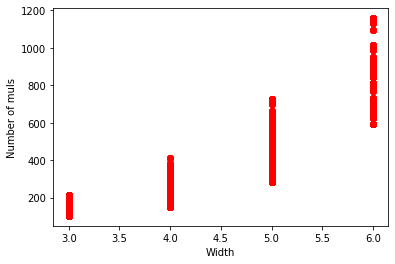

In [37]:
# List with width of all permutations of the elimination list ('V', 'H', 'S', 'L', 'O', 'A', 'T')
widthList = []
# List with number of multiplications ofr the same permutations
mulList = []
for i, p in enumerate(permutations(('V', 'H', 'S', 'L', 'O', 'A', 'T'))):
    # Call the width function for the permutation in p
    w = width(icu_factors, p)                                                    # Calculate width: 1 line
    widthList.append(w)
    # Initialize muls
    muls = 0    
    # Call the VE function to compute the number of multiplications
    VE(icu_factors, p, outcomeSpace)                                                           # Call VE: 1 line
    mulList.append(muls)
    # Print some information since it may take some time to finish
    if (i % 100 == 0):
        print("%6d %6d %1.6f" % (i, w, muls))
# Generate plots
plt.plot(widthList, mulList, 'ro')
plt.xlabel("Width")
plt.ylabel("Number of muls")
plt.show()

We can see that width correlates well with the number of multiplications. More importantly, small widths have a small variance that indicates a good performance independently of a specific order. The plot appears to grow exponentially.

## Min-degree heuristic

Having a good ordering is central to VE algorithm performance. However, it is known that finding the best order is an NP-Hard problem.

For a small number of variables, we can use the `width` function to test all possible orderings. The next cell implements such an approach for all nine variables.

In [38]:
minW = math.inf
for i, p in enumerate(permutations(('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B', 'C'))):
    # Call the width function for the permutation in p
    w = width(icu_factors, p)
    if (w < minW):
        minP = p
        minW = w
print("Order with minimal width %d: " % minW)

print(minP)

Order with minimal width 3: 
('H', 'S', 'V', 'L', 'O', 'A', 'T', 'B', 'C')


### Exercise

For larger networks, we will need to use a heuristic approach. One of the simplest is known as min-degree. Min-degree and several other ordering heuristics operate over an undirected graph known as *interaction graph*.

The interaction graph is simply a graph in which the nodes are variables, and the edges connect variables that appear in the domain of the same factor. 

We will start implementing `interactionGraph` a function that receives a dictionary of factors and returns an interaction graph. We use the same adjacency list representation of the first tutorial.

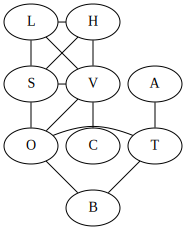

In [39]:
def interactionGraph(factors, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns an adjacency list representation of the induced graph
    """        
    # Initialize representation that is a dictionary of node ids
    ig = {}                                                            # Initialization: 1 line
    # Initialize each adjacency list with an empty list
    for var in outcomeSpace.keys():
        ig[var] = []                                                   # Initialization: 1 line
    for f_id in factors.keys():
        for var1 in factors[f_id]['dom']:
            for var2 in factors[f_id]['dom']:
                if var1 != var2 and var2 not in ig[var1]:
                    # Connect node var1 with var2 by adding var2 in the adjaceny list of var1
                    ig[var1].append(var2)                                                 # Add var2 to adj list of var1: 1 line
    return ig


##############
# Test code

ig = interactionGraph(icu_factors, outcomeSpace)
dot = Graph(engine="neato", comment='Interaction graph example',strict=True)
dot.attr(overlap="false", splines="true")

# List of positions for each node
# We use node positions to replicate the previous figure
# This can be removed if the nodes do not need to be presented in a specific order
pos = {
    'B': '1,0!',
    'O': '0,1!',
    'C': '1,1!',
    'T': '2,1!',
    'S': '0,2!',
    'V': '1,2!',
    'A': '2,2!',
    'L': '0,3!',
    'H': '1,3!',
}

for v in ig.keys():
    dot.node(str(v), pos=pos[v])
    # dot.node(str(v))              # Use this line instead of the previous one to position the nodes in random order

for v in ig.keys():
    for w in ig[v]:
        dot.edge(str(v), str(w))

dot

If your code is correct, you should see the following induced graph:

![IG Graph](img/IG.png "Graph exercise")

Also, this is the ICU network graph for reference:

![ICU Graph](img/ICU_graph.png "Graph exercise")

From this representation, we can see that a min-degree heuristic should start eliminating variables such as `A` and `C`.

### Exercise

Now, let's implement the `minDegree` function that receives an induced graph and returns a list with a variable elimination order.

This function will suggest the nodes with the smallest degree first. Remember that the degree of a node is the number of edges connected to that node. Every time we select a node as the next to be eliminated, we need to remove that node from the graph. This operation will reduce the degree of the nodes directly connected to the removed one.

In [40]:
def minDegree(igGraph):
    """
    argument 
    `ig`, an induced graph,
    Returns a elimination order according to the min-degree heuristic
    """      
    # Initialize order with empty list. This variable will have the answer in the end of the execution
    order = list()                                                      # Initialization: 1 line
    # Let's make a copy of iGraph to guarantee we will not destroy it
    ig = igGraph.copy()
    # While the induced graph has nodes to be eliminated
    while ig:
        # Initialize minDegree with a large number: math.inf
        minDegree = math.inf                                              # Initialization: 1 line
        for var in ig.keys():
            # Test if var has a degree smaller than minDegree
            if len(ig[var]) < minDegree:
                # We have found a new candidate to be the next eliminated variable. Let's save its degree and name
                minDegree = len(ig[var])                                      # Store the degree of var: 1 line
                minVar = var                                         # Store the variable name (var): 1 line
        # We need to connected the neighbours of minVar, let us start using combinations function to find all pairs of minVar's neighbours
        for neigh in combinations(ig[minVar], 2):
            # We need to check if these neighbour are not already connected by an edge
            if not neigh[0] in ig[neigh[1]]:
                # Now, let's connected them. Remember, this is an undirected graph, so we need two edges
                ig[neigh[0]].append(neigh[1])                             # Store neigh[1] to the adjacency list of neigh[0]: 1 line
                ig[neigh[1]].append(neigh[0])                             # Store neigh[0] to the adjacency list of neigh[1]: 1 line
        # Insert in order the variable in minVar
        order.append(minVar)                                            # Store minVar in the list order: 1 line
        # Now, we need to remove minVar from the adjacency list of every node
        for var in ig.keys():
            if minVar in ig[var]:
                ig[var].remove(minVar)                                  # Remove minVar from the adjacency list of var: 1 line
        # As well as remove minVar adjacency list from the interaction graph
        del ig[minVar]                                                  # Remove minVar adjacency list from the iteraction graph: 1 line
    return order


####################
# Test code

print(minDegree(interactionGraph(icu_factors, outcomeSpace)))

['A', 'C', 'T', 'B', 'O', 'H', 'L', 'V', 'S']


If your code is correct, you should see the following output:

```
['A', 'C', 'T', 'B', 'O', 'H', 'L', 'V', 'S']
```

We can compare the width of the ordering provided by the min-degree heuristic to some other order:

In [41]:
print(width(icu_factors, ('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B', 'C')))
print(width(icu_factors, minDegree(interactionGraph(icu_factors, outcomeSpace))))

5
3


Similarly, we can compare the number of additions and multiplications:

In [42]:
adds = 0
muls = 0
VE(icu_factors, ('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B', 'C'), outcomeSpace)
print(adds)
print(muls)

adds = 0
muls = 0
VE(icu_factors, minDegree(interactionGraph(icu_factors, outcomeSpace)), outcomeSpace)
print(adds)
print(muls)

358
342
79
74


## Answering Queries

We have implemented a good amount of code, but we do not have a proper function to answer probabilistic queries with VE. We can put together everything we learned today in this function. This time, we will let you free to implement your code.

But, first, let's bring some functions from previous tutorials.

In [43]:
def evidence(var, e, outcomeSpace):
    """
    argument 
    `var`, a valid variable identifier.
    `e`, the observed value for var.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns dictionary with a copy of outcomeSpace with var = e
    """    
    newOutcomeSpace = outcomeSpace.copy()      # Make a copy of outcomeSpace with a copy to method copy(). 1 line
    newOutcomeSpace[var] = (e,)                # Replace the domain of variable var with a tuple with a single element e. 1 line
    return newOutcomeSpace

In [44]:
def normalize(f):
    """
    argument 
    `f`, factor to be normalized.
    
    Returns a new factor f' as a copy of f with entries that sum up to 1
    """ 
    table = list()
    sum = 0
    for k, p in f['table'].items():
        sum = sum + p
    for k, p in f['table'].items():
        table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}

### Exercise

Now it is your turn, implement a function `query` that receives as arguments:

1. a dictionary of factors, 
2. an elimination order, 
3. a list of query variables 
4. and a list of evidence 

and returns $P(variables|evidence)$.

Before you start, some important observations:

1. Remove the query variables from the elimination order list.
2. It is up to you if you want to remove the evidence variables from the elimination list.
3. At the end of the execution, `factors` will have one or more factors. These are the factors that involve query variables. It is common practice to join all those factors in a single factor.
4. A final normalization step will answer queries in the format P(Q|e).

In [45]:
def query(factors, order, outcomeSpace, q_vars, **q_evi):
    """
    argument 
    `factors`, a dictionary of factors
    `order`, a list with variable elimination order
    `outcomeSpace`, dictionary will variable domains
    `q_vars`, list of variables in query head
    `q_evi`, dictionary of evidence in the form of variables names and values
    
    Returns a new factor with P(Q, e) or P(Q|e)
    """
    # Fill in this function
    # Let's make a copy of these structures, since we will reuse the variable names
    outSpace = outcomeSpace.copy()
    
    # First, we set the evidence 
    for var_evi, e in q_evi.items():
        outSpace = evidence(var_evi, e, outSpace)
        
    for q_var in q_vars:
        order.remove(q_var)
 
    f = VE(factors, order, outSpace)
    
    first = True
    for f_id in f.keys():
        if first:
            # We need this code since join requires two factors, so we save the first one in fx and wait for the next
            fx = f[f_id]
            first = False
        else:
            # Join fx and f[f_id] and save the result in fx
            fx = join(fx, f[f_id], outSpace)    
    
    return normalize(fx)
    
    return None

#########################
# Test code
#########################
printFactor(query(icu_factors, minDegree(interactionGraph(icu_factors, outcomeSpace)), outcomeSpace, 'L', C=2))

|   L |        Pr |
|-----+-----------|
|   0 | 0.947722  |
|   1 | 0.0522777 |


If your implementation is correct then you should see the following output:

```
|   L |        Pr |
|-----+-----------|
|   0 | 0.947722  |
|   1 | 0.0522777 |
```

That is all for today. See you next week!

In [54]:
factors = { 'A': {
        'dom': ('A'),
        'table': odict([
        ((0,), 0.99),
        ((1,), 0.01), ])
        },
        'D': {
        'dom': ('B', 'C', 'D'),
        'table': odict([
        ((0, 0, 0), 1), 
        ((0, 0, 1), 0), 
        ((0, 1, 0), .2), 
        ((0, 1, 1), .8), 
        ((1, 0, 0), .1), 
        ((1, 0, 1), .9), 
        ((1, 1, 0), .05), 
        ((1, 1, 1), .95),
        ]) },
        'B' : {
        'dom': ('A', 'B'),
        'table': odict([
        ((0, 0), 0.25), 
        ((0, 1), 0.75),
        ((1, 0), 0.8), 
        ((1, 1), 0.2),
        ]) },
        'E' : {
        'dom': ('C', 'E'),
        'table': odict([
        ((0, 0), 1), 
        ((0, 1), 0), 
        ((1, 0), .3), 
        ((1, 1), .7),
        ]) },
        'C' : {
        'dom': ('A', 'C'),
        'table': odict([ 
        ((0, 0), .9), 
        ((0, 1), .1), 
        ((1, 0), .2), 
        ((1, 1), .8),
        ]) },
        }

outcomeSpace = dict(
    A=(0,1),
    B=(0,1),
    C=(0,1),
    D=(0,1),
    E=(0,1)
)

In [55]:
printFactor(query(factors, minDegree(interactionGraph(factors, outcomeSpace)), outcomeSpace, ('D','E')))

|   E |   D |         Pr |
|-----+-----+------------|
|   0 |   0 | 0.294222   |
|   0 |   1 | 0.630878   |
|   1 |   0 | 0.00701575 |
|   1 |   1 | 0.0678842  |
